In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from tools.linking_tools import *
from tools.collection_tools import Collection
from tools.helpers import range_to_pagenumbers,clean_all_csv
from pathlib import Path

/data/anaconda/envs/py37torch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/anaconda/envs/py37torch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/anaconda/envs/py37torch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/data/anaconda/envs/py37torch/lib/python3.7/site-packages/ten

In [4]:
clean_all_csv()

In [5]:
ROOT = Path("/deezy_datadrive/kaspar-playground/npd/")
DATA = ROOT / 'Data'
IN_PATH = DATA / "Original"
OUT_PATH = DATA /  "Processed"
MODELS_PATH = ROOT / 'Models'

In [6]:
editions_all = pickle.load(open('../editions_all.pickle','rb'))

#selected_years = [int(p.name.split("_")[1]) for p in list(IN_PATH.glob('MPD_*'))]

selected_years = [1846,1847,1851,1856,1858,
                  1860,1863,1865,1868,
                  1870,1873,1875,1878,
                  1880,1883,1885,1888,
                  1890,1893,1895,1898,
                  1900,1905,1910,1915,1920
                 ]

editions = {y:editions_all[y] for y in selected_years}
editions = range_to_pagenumbers(editions)

## Load and vectorize collection

In [7]:
collection = Collection(editions,IN_PATH,OUT_PATH)
#npd_collection = collection.load()

In [8]:
#from tools.analysis_tools import clean_all_csv
#clean_all_csv()

In [9]:
npd_collection = collection.load_csv_from_path(path=Path('./csv_dump_final'),suffix='')
npd_collection.shape

(43361, 17)

In [10]:
recordlinker = RecordLinker(npd_collection)
#recordlinker.collection_df.head()

number of books in the collections:  26


In [11]:
fields = ['S-TITLE', 'S-POL', 'DISTRICT',
          'COUNTY', 'S-PRICE','D-EST', 'D-PUB', 
          'E-LOC', 'E-ORG', 'E-PER']
recordlinker.vectorize(fields)

number of entries in the collection:  43361


## Annotate

In [12]:
print('Years in collection.')
print(recordlinker.collection_df.YEAR.unique())

Years in collection.
[1846 1847 1851 1856 1858 1860 1863 1865 1868 1870 1873 1875 1878 1880
 1883 1885 1888 1890 1893 1895 1898 1900 1905 1910 1915 1920]


In [24]:
annotator = Annotator(1895,1898,recordlinker)

Data vectorized.
(43361, 17)
43361 2447
Building Index!
Finished!


In [25]:
annotator.annotate_examples(30)

HTML(value='0 examples annotated, 151 examples left')

Output()

In [26]:
annotator.add()

In [27]:
print(annotator)

< Annotators with 150 annotations >


In [28]:
annotator.save(link_dump_folder=Path('./link_dump'))

Saved 150 annotation to link_dump/link_dump_173778.pickle
Removed previous annotations


## Train a model

In [29]:
link_clf = RLModelTrainer(recordlinker)
link_clf.load_annotations(annotations_dump=Path('./link_dump/'))
link_clf.export_csv(save_to=Path('./link_dump/training'))


Data vectorized.
Loaded 3300 annotations
(3300, 2)
(3291, 2)


In [30]:
link_clf = RLModelTrainer(recordlinker)
link_clf.train_with_transformer(MODELS_PATH, data_folder=Path('./link_dump/training'))

                (dropout): Dropout(p=0.1, inplace=False)
              )
            )
            (intermediate): BertIntermediate(
              (dense): Linear(in_features=768, out_features=3072, bias=True)
            )
            (output): BertOutput(
              (dense): Linear(in_features=3072, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (10): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, o

## Apply a model

In [11]:
annotator = Annotator(1860,1865,recordlinker)

Data vectorized.
(27272, 16)
27272 1223
Building Index!
Finished!


In [17]:
model = annotator.load_model(MODELS_PATH / 'link_classifier'/ 'best-model.pt')

2021-04-01 18:13:09,843 loading file /deezy_datadrive/kaspar-playground/npd/Models/link_classifier/best-model.pt


In [18]:
annotator.classify(model,verbose=True)

         None
E-PER                                                   Edward S . Kenney
S-TITLE-ALT                                                          None
TEXT                    WATERFORD NEWS . Friday , Price 3d . and 4d . ...
DISTRICT_DESCRIPTION    Is a city and large seaport , and is the capit...
YEAR                                                                 1865
Name: 4112, dtype: object
----------


----------
id                                                          MPD_1860_1003
S-TITLE                                            WEXFORD CONSTITUTION .
S-POL                                                        conservative
CATEGORY                                                            irish
DISTRICT                wexford . — ( in the province of leinster and ...
COUNTY                     in the province of leinster and county wexford
S-PRICE                                                         4d<SEP>5d
D-EST                                           

FileNotFoundError: [Errno 2] No such file or directory: '../link_dump/predictions'

## Create Chains

In [38]:
stances = {'liberal-conservative':1,'liberal':1,'advanced-liberal':1,'whig':1,
           "conservative":-1,"tory":-1,'tory ( old )':-1,
           "neutral":0,"independent":0,}


In [39]:
from functools import partial
import Levenshtein

canonical_forms = ['liberal','neutral','conservative','independent',
                'liberal-conservative','independent-liberal',
                'independent-conservative','constitutional',
                'liberal-independent','radical','unionist','tory','whig',
                'liberal-unionist','protestant-conservative','tory ( old )',
                'advanced-liberal','conservative-independent']

def normalize_token_by_levenshtein(token,canonical_forms):
    
    if token in canonical_forms:
        return token
    elif isinstance(token,np.float):
        return 'None'
    
    f = partial(Levenshtein.distance,token.lower())
    distances = list(map(f,canonical_forms))
    min_dist_id = np.argmin(distances)
    
    if min(distances) <= 2:
        return canonical_forms[min_dist_id]
    return token.lower()


In [40]:
from scipy.spatial.distance import euclidean 
def shift_in_political_leaning(df):
    
    pol = df['S-POL'].to_list()
    years = df['year'].to_list()
    year_dict = defaultdict(int)
    
    for i in range(len(pol)-1):
        
        if not(pol[i] and pol[i+1]): continue
        p1,p2 = str(pol[i]).lower(),str(pol[i+1]).lower()
        p1 = normalize_token_by_levenshtein(p1,canonical_forms)
        p2 = normalize_token_by_levenshtein(p2,canonical_forms)
        if p1 in stances and p2 in stances:
            dist = euclidean(stances[p1],stances[p2])
            if dist > 0:
                if stances[p1] > stances[p2]:
                    direction = 1 # from left to right
                elif stances[p1] < stances[p2]:
                    direction = -1 # from right to left
            else:
                direction = 0
            
            year_dict[years[i+1]] = dist * direction
                        
    return year_dict

ydicts = []

for chain in linkchainer.__sort__():
   
    df = linkchainer.print_chain(chain[1].chain)
    ydicts.append(shift_in_political_leaning(df))
        

In [41]:
to_left, to_right = defaultdict(int),defaultdict(int)
for yd in ydicts:
    for y,s in sorted(yd.items(),key=lambda x: x[0]):
        if s > 0:
            to_left[y]+=1
        elif s < 0:
            to_right[y]-=1

In [42]:
import seaborn as sns
sns.set()

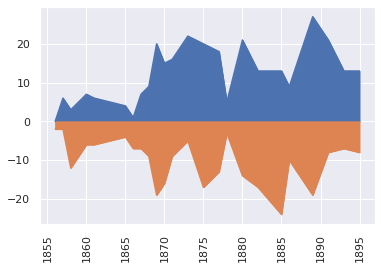

In [43]:
pol_over_time = pd.DataFrame([to_left,to_right]).T
pol_over_time.columns = ['moved to left','moved to right']
pol_over_time.sort_index(inplace=True)
pol_over_time.plot.area(rot=90,legend=False)

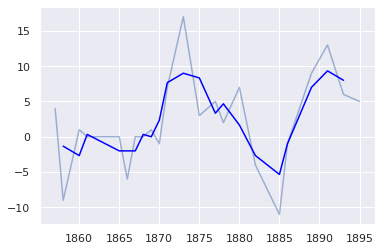

In [37]:
pol_over_time['shift'] = pol_over_time['moved to left'] - pol_over_time['moved to right'].abs()
pol_over_time["shift"].plot(alpha=.5)
pol_over_time["shift"].rolling(3,center=True).mean().plot(color='blue')

In [44]:
df.columns

Index(['Unnamed: 0', 'id', 'S-TITLE', 'D-PUB', 'S-PRICE', 'S-POL', 'D-EST',
       'E-ORG', 'DISTRICT', 'TEXT', 'E-LOC', 'E-PER', 'S-ADV', 'S-TITLE-ALT',
       'I-REL', 'I-SOC', 'I-POL', 'A-CLASS', 'I-ECON', 'year'],
      dtype='object')

## Link to JISC

In [46]:
bl_meta = pd.read_csv("../newspaper_metadata/BL newspaper holdings British and Irish titles v2a.csv", 
                      dtype={'Title ID': object,
                            "First year of pubication": object,
                            "Last year of publication": object})
bl_meta.head()

,Title ID,BNB number,ISSN,Publication title,Edition,Preceding title,Succeeding title,Country,Town/City,First geographical subject heading,Subsequent geographical subject heading,General area of coverage,Specific area of coverage,First year of pubication,Last year of publication,Publication dates - more information,First year held,Last year held,Holdings - more information,Online (all or part)
0,002841953,NaN,NaN,"Corante, or, Newes from Italy, Germany, Hungar...",NaN,NaN,NaN,England,London,NaN,NaN,NaN,NaN,1621,NaN,NaN,NaN,NaN,NaN,Y
1,002852602,NaN,NaN,A Relation of the late Occurrents which haue h...,NaN,NaN,NaN,England,London,NaN,NaN,NaN,NaN,1622,1622,NaN,NaN,NaN,NaN,Y
2,002852624,NaN,NaN,A Relation of the late Occurrents which haue h...,NaN,NaN,NaN,England,London,NaN,NaN,NaN,NaN,1622,1622,NaN,NaN,NaN,NaN,Y
3,002852630,NaN,NaN,A Relation of the late Occurrents which haue h...,NaN,NaN,NaN,England,London,NaN,NaN,NaN,NaN,1622,1622,NaN,NaN,NaN,NaN,Y
4,002852631,NaN,NaN,A Relation of the late Occurrents which haue h...,NaN,NaN,NaN,England,London,NaN,NaN,NaN,NaN,1622,1622,NaN,NaN,NaN,NaN,Y


In [47]:
jisc_meta = pd.read_csv("../newspaper_metadata/JISCcombined_edited.csv", dtype={'System ID': str})
jisc_meta["System ID"] = jisc_meta["System ID"].str.strip()
jisc_meta = jisc_meta.iloc[:114]
jisc_meta.head()

,Newspaper Title,System ID,NLP,JISC,Title,Normalised Title,Abbr,Start,Unnamed: 8,Unnamed: 9,End,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,The Aberdeen Journal and general advertiser fo...,013921360,31.0,JISC1,Aberdeen Journal,Aberdeen Journal,ANJO,1.0,Jan,1800.0,23.0,Aug,1876.0,NaN
1,Aberdeen Weekly Journal,013921362,32.0,JISC1,Aberdeen Weekly Journal,Aberdeen Journal,ANJO,30.0,Aug,1876.0,31.0,Dec,1900.0,NaN
2,Baner,013906328,36.0,JISC1,Baner Cymru,Baner,BNER,4.0,Mar,1857.0,28.0,Sep,1859.0,NaN
3,Baner ac Amserau Cymru,013906329,37.0,JISC1,Baner ac Amserau Cymru,Baner,BNER,5.0,Oct,1859.0,29.0,Dec,1900.0,NaN
4,Belfast News-Letter,013943744,38.0,JISC1,Belfast News-Letter,Belfast News-Letter,BNWL,1.0,Jan,1828.0,31.0,Dec,1900.0,NaN


In [48]:
jisc_merged = jisc_meta[['Newspaper Title', "System ID"]].merge(bl_meta, 
                                                                left_on='System ID',
                                                                right_on="Title ID",
                                                               how='left')
print(jisc_meta.shape,jisc_merged.shape)

(114, 14) (114, 22)


In [49]:
jisc_merged.columns

Index(['Newspaper Title', 'System ID', 'Title ID', 'BNB number', 'ISSN',
       'Publication title', 'Edition', 'Preceding title', 'Succeeding title',
       'Country', 'Town/City', 'First geographical subject heading',
       'Subsequent geographical subject heading', 'General area of coverage',
       'Specific area of coverage', 'First year of pubication',
       'Last year of publication', 'Publication dates - more information',
       'First year held', 'Last year held', 'Holdings - more information',
       'Online (all or part)'],
      dtype='object')

In [50]:
jisc_merged['First year of pubication'] = jisc_merged['First year of pubication'].fillna('0').astype(dtype=np.int64)
jisc_merged['Last year of publication'] = jisc_merged['Last year of publication'].fillna('2020').astype(dtype=np.int64)

In [51]:
jisc_merged.head()

,Newspaper Title,System ID,Title ID,BNB number,ISSN,Publication title,Edition,Preceding title,Succeeding title,Country,...,Subsequent geographical subject heading,General area of coverage,Specific area of coverage,First year of pubication,Last year of publication,Publication dates - more information,First year held,Last year held,Holdings - more information,Online (all or part)
0,The Aberdeen Journal and general advertiser fo...,013921360,013921360,NaN,NaN,The Aberdeen Journal and General Advertiser fo...,NaN,Aberdeen Journal. no. 1774-2589 (7 Jan. 1782-...,Aberdeen Weekly Journal and General Advertiser...,Scotland,...,Grampian (Scotland),Scotland--Grampian,Aberdeen,1797,1876,NaN,1797,1876,number 2590-6711 (29 August 1797-23 August 1876),Y
1,Aberdeen Weekly Journal,013921362,013921362,NaN,NaN,Aberdeen Weekly Journal and General Advertiser...,NaN,The Aberdeen Journal and General Advertiser f...,Aberdeen Weekly Journal. no. 8137-10792 (23 De...,Scotland,...,Grampian (Scotland),Scotland--Grampian,Aberdeen,1876,1903,NaN,1876,1903,number 6712-8136 (30 August 1876-16 December 1...,Y
2,Baner,013906328,013906328,NaN,NaN,Baner Cymru,NaN,NaN,"Baner ac Amserau Cymru. cyf.3.rhif.136, etc (5...",Wales,...,Denbighshire (Wales),Wales--Clwyd,Denbigh,1857,1859,NaN,1857,1859,cyf 1 rhif 1 - cyf 3 rhif 135 (4 March 1857 - ...,Y
3,Baner ac Amserau Cymru,013906329,013906329,NaN,NaN,Baner ac Amserau Cymru,NaN,Baner Cymru. cyf.1.rhif.1 - cyf.3.rhif.135 (4...,Faner. 7 Jan.1972-17 April 1992,Wales,...,Denbighshire (Wales),Wales--Clwyd,Denbigh,1859,1971,NaN,1859,1971,"cyf 3 rhif 136, etc (5 October 1859 - 30 Decem...",Y
4,Belfast News-Letter,013943744,013943744,NaN,NaN,The Belfast News-Letter,NaN,Belfast News-Letter and General Advertiser. 1...,News Letter. 3 Sept. 1962-,Northern Ireland,...,Northern Ireland,Ireland,Belfast,1792,1962,NaN,1792,1962,21/25 December 1792; 29 January 1799; 21 May 1...,Y


In [53]:
# has to be published before 1900
# needs at least one publication after 1855
mask = np.array((jisc_merged["Country"] == "England") & \
        (jisc_merged['First year of pubication'] < 1900) & \
        (jisc_merged['Last year of publication'] > 1855) & \
        (jisc_merged['Specific area of coverage'] != "London"))

In [54]:
jisc = jisc_merged.loc[mask]
jisc.shape

(40, 22)

In [55]:
jisc["Publication title"]

5                                  Birmingham Daily Post
8                               The Bristol Mercury, etc
9      The Bristol Mercury and Daily Post, Western Co...
21                                     The Derby Mercury
31               Hampshire Telegraph and Naval Chronicle
32        Hampshire Telegraph, and Sussex Chronicle, etc
36                The Hull Packet; and East Riding Times
40                                   The Ipswich Journal
41                              Jackson's Oxford Journal
42                              Jackson's Oxford Journal
43                                     The Leeds Mercury
44                                Liverpool Mercury, etc
51                            The Newcastle Courant, etc
52                          The Newcastle Weekly Courant
54                                         Northern Echo
61                       Oxford Journal and Country News
65       The Preston Chronicle and Lancashire Advertiser
71     Trewman's Exeter Flying 

In [56]:
from collections import Counter
all_titles = []
id = 0
for ch in linkchainer.__sort__():
    df = linkchainer.print_chain(ch[1].chain)
    titles = Counter(df['S-TITLE'])
    years = list(df['year'])
    n_ids = list(df["id"])
    meta = years[0],years[-1],id,n_ids
    
    for t in list(titles.items()):
        t = list(t)
        t.extend(meta)
        all_titles.append(t)
    id+=1

In [57]:
df_all_titles = pd.DataFrame(all_titles, columns=['TITLE',"FREQ","BEGIN","END","ID","NIDS"])
df_all_titles.TITLE.fillna('NAN',inplace=True)
df_all_titles.head()

,TITLE,FREQ,BEGIN,END,ID,NIDS
0,BERWICK ADVERTISER,21,1855,1895,0,"[MPD_1855_24, MPD_1856_29, MPD_1857_23, MPD_18..."
1,PAPERS,1,1855,1895,0,"[MPD_1855_24, MPD_1856_29, MPD_1857_23, MPD_18..."
2,""" BERWICK ADVERTISER",1,1855,1895,0,"[MPD_1855_24, MPD_1856_29, MPD_1857_23, MPD_18..."
3,distric BERWICK ADVERTISER,1,1855,1895,0,"[MPD_1855_24, MPD_1856_29, MPD_1857_23, MPD_18..."
4,BERWICKSHIRE ADVERTISER,1,1855,1895,0,"[MPD_1855_24, MPD_1856_29, MPD_1857_23, MPD_18..."


In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,max_df=.9,analyzer='char', ngram_range=(1,4))
X = vectorizer.fit_transform(df_all_titles.TITLE)

In [59]:
from annoy import AnnoyIndex
index = AnnoyIndex(X.shape[1], metric='euclidean')

for i,v in enumerate(X):
    index.add_item(i, v.todense().T)
index.build(50)


True

In [60]:
from pigeon import annotate
row_idx = 0
all_annotations = []

In [70]:
if row_idx > jisc.shape[0]:
    print('Done.')
else:
    print(f"at {row_idx} of {jisc.shape[0]} newspapers")
    row = jisc.iloc[row_idx]
    title = row["Publication title"]
    print(row)

    #print(title.upper())
    vector = vectorizer.transform([title]).todense().reshape(-1).T
    candidates = index.get_nns_by_vector(vector,10)
    annotations = annotate(
      [(title.upper(),df_all_titles.iloc[c].TITLE,row["System ID"],df_all_titles.iloc[c].NIDS) for c in candidates],
      options=['same', 'different']
        )


at 4 of 40 newspapers
Newspaper Title                                      Hampshire Telegraph and Naval Chronicle
System ID                                                                          013924140
Title ID                                                                           013924140
BNB number                                                                               NaN
ISSN                                                                                     NaN
Publication title                                    Hampshire Telegraph and Naval Chronicle
Edition                                                                                  NaN
Preceding title                             Hampshire Telegraph, and Sussex Chronicle, et...
Succeeding title                           Hampshire Telegraph & Post and Naval Chronicle...
Country                                                                              England
Town/City                                       

HTML(value='0 examples annotated, 11 examples left')

Output()

Annotation done.


In [69]:
row_idx+=1
all_annotations.extend(annotations)
len(all_annotations)

40

In [ ]:
all_annotations[0]

In [ ]:
# with open("../link_dump/jisc_links/jisc_links.pickle",'wb') as out_pickle:
#     pickle.dump(all_annotations,out_pickle)

In [ ]:
with open("../link_dump/jisc_links/jisc_links.pickle",'rb') as in_pickle:
    jisc_annotations = pickle.load(in_pickle)

In [ ]:
def add_identifiers(jisc_annotations,jisc_df,csv_path="../csv_dump/"):
    links = defaultdict(list)
    for ((t1, t2, j_id, npd_ids), anno) in jisc_annotations:
        start = int(jisc_df[jisc_df['System ID']==j_id]['First year of pubication'])
        end = int(jisc_df[jisc_df['System ID']==j_id]['Last year of publication'])
        if anno == "same":
            for npd_id in npd_ids:
                _, year, id = npd_id.split("_")
                if int(year) in range(start, end + 1):
                    links[year].append([npd_id,j_id])
    return links

links = add_identifiers(jisc_annotations,jisc)


In [ ]:

csv_path= Path("../csv_dump")

csv_path_out = Path("../csv_dump_out/")
csv_path_out.mkdir(exist_ok=True)
for year, link_list in tqdm(links.items()):
    ## code is missing here
    ## filter links
    seen = [] ### !!!! important duplicate links use set() on link list link_list, or something
    unique_links = []
    for l1,l2 in link_list:
        if l1 not in seen:
            unique_links.append([l1,l2])
            seen.append(l1)
        
    df = pd.read_csv(csv_path / f"MPD_{year}.csv")
    df_links = pd.DataFrame(unique_links,columns=['npd_id','jisc_id'])
    df_merged = df.merge(df_links,left_on='id',right_on='npd_id',how="left")
    
    df_merged['politics'] = df_merged['S-POL'].apply(normalize_token_by_levenshtein,
                                                    canonical_forms=canonical_forms)
    
    
    df_merged.to_csv(csv_path_out / f"MPD_{year}.csv")
    

In [ ]:
df_merged.head(3)

## Timeline

In [ ]:


def bias_by_over_time(csv_path_out,labels):
    rows = []
    for p in csv_path_out.glob("**/*.csv"):
        year = int(p.stem.split("_")[-1])
        df = pd.read_csv(p)
        ratioLib = df[df.politics.isin(labels)].shape[0] / df.shape[0]
        jisc_np = df[~df.jisc_id.isnull()]
        ratioLibJisc = jisc_np[jisc_np.politics.isin(labels)].shape[0] / jisc_np.shape[0]
        rows.append([year,ratioLib,ratioLibJisc])
        
    pol_df = pd.DataFrame(rows,columns=['year','all',"jisc"])
    pol_df.set_index('year',inplace=True)
    pol_df.sort_index(inplace=True)
    return pol_df

pol_df = bias_by_over_time(csv_path_out,['liberal','liberal-conservative','liberal-unionist']) 
# ['neutral','independent']
# ['conservative','tory']

In [ ]:
pol_df.plot()

In [ ]:
lib_df = bias_by_over_time(csv_path_out,['liberal','liberal-conservative','liberal-unionist']) 

con_df = bias_by_over_time(csv_path_out,['conservative','tory']) 
lib_df['diff'] = lib_df['jisc'] - lib_df['all']

con_df['diff'] = con_df['jisc'] - con_df['all']
lib_df['diff'].rolling(5).mean().plot()
con_df['diff'].rolling(5).mean().plot()

## stuff lost

## Text

In [171]:
query_tokens = ['working classes','working class','working men',
                'working-man','rights of labour',
                'working people','working population',
                'labouring classes']
query_expr = r"(?:{})".format('|'.join(query_tokens))
query_expr

'(?:working classes|working class|working men|working-man|rights of labour|working people|working population|labouring classes)'

In [173]:
import re
pattern = re.compile(query_expr)
is_hit = lambda x, pattern: 1 if pattern.findall(x) else 0

In [178]:
recode_pol = {
    'conservative':'conservative',
    'constitutional':'conservative',
    'czlconservative':'conservative',
    'independent':'neutral',
    'independent-conservative':'neutral',
    'independent-liberal':'neutral',
    'liberal-conservative':'liberal',
    'liberal-independent':'liberal',
    'liberal':'liberal',
    'liberal<sep>amal':'liberal',
    'neutral':'neutral',
    'protestant-conservative':'conservative',
    'radical':'radical',
    'tory':'conservative',
    'whig':'liberal',
    'ependent':'neutral',
    'neduautral':'neutral',
    'liberal<sep>conservative':'liberal',
    #'liberal-unionist':'liberal',
    'tory ( old )':'conservative',
    'advanced-liberal':'liberal',
    'protestant<sep>conservative':'conservative',
    'non-party':'neutral',
    'protestant':'conservative',
    'liberal<sep>liberal':'liberal',
    'liberal<sep>independent':'liberal'
}

In [184]:
csv_path_out = Path("../csv_dump_out/")
result = defaultdict(dict)

for p in csv_path_out.glob("**/*.csv"):
    year = int(p.stem.split("_")[-1])
    if not year in period: continue
    df = pd.read_csv(csv_path_out / f"MPD_{year}.csv")
    df.replace({'politics':recode_pol},inplace=True)
    df["hits"] = df.TEXT.str.lower().apply(is_hit,pattern=pattern)
    df = df[df.politics.isin(['liberal','conservative','neutral'])]
    result[year] = (100*df.groupby('politics')['hits'].sum() / df.groupby('politics')['hits'].count()).to_dict()



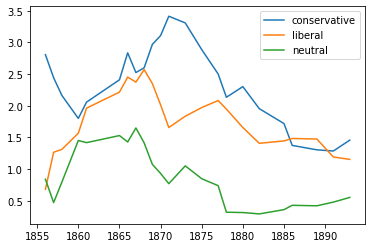

In [186]:
df_pol = pd.DataFrame.from_dict(result,orient='index')
df_pol.head()
df_pol.sort_index(inplace=True)
df_pol.rolling(3,center=True).mean().plot()

## Place

In [30]:
with open("/deezy_datadrive/kaspar-playground/other/wikigaz_en.pkl",'rb') as in_pickle:
    wikigaz = pickle.load(in_pickle)

In [31]:
uk_bb_coord = (-7.57216793459, 49.959999905, 1.68153079591, 58.6350001085)

In [39]:
ukgaz_mask =  (wikigaz.lon > -7.57216793459) & (wikigaz.lon < 1.68153079591) & \
              (wikigaz.lat > 49.959999905) & (wikigaz.lat < 58.6350001085) 

In [40]:
ukgaz =wikigaz[ukgaz_mask]

In [41]:
ukgaz[ukgaz.altname=='Durham']

,altname,pid,lat,lon
355703,Durham,List_of_youth_hostels_in_England_and_Wales,54.7732,-1.57460
360306,Durham,Durham_(Gilesgate)_railway_station,54.7787,-1.56300
430265,Durham,HM_Prison_Durham,54.7733,-1.56806
586246,Durham,Durham_District,54.7815,-1.51880
688113,Durham,City_of_Durham_(UK_Parliament_constituency),54.7770,-1.55600
1086523,Durham,County_Durham,54.6667,-1.83333
1218216,Durham,"Durham,_England",54.7761,-1.57330


In [42]:
ukgaz['name'] = ukgaz.altname.str.lower()
ukgaz['pid_lower'] = ukgaz.pid.str.lower()

/data/anaconda/envs/py37torch/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/data/anaconda/envs/py37torch/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [164]:
def create_coord_df(target_lab,contrast_labels,col='politics'):


    target,contrast = [],[]

    csv_path_out = Path("../csv_dump_out/")
    for p in csv_path_out.glob("**/*.csv"):
        year = int(p.stem.split("_")[-1])
        if not year in period: continue
        
        df = pd.read_csv(csv_path_out / f"MPD_{year}.csv")
        df['in_jisc'] = df.jisc_id.apply(lambda x: 'in_jisc' if x else 'not_in_jisc')
        target.extend(df[df[col]==target_lab]["E-LOC"])
        contrast.extend(df[df[col].isin(contrast_labels)]["E-LOC"])
        
    target = [' '.join(l.split("<SEP>")) for l in target if isinstance(l,str)]
    contrast = [' '.join(l.split("<SEP>")) for l in contrast if isinstance(l,str)]
    
    vectorizer = CountVectorizer(min_df=5,max_df=.9)
    counts = vectorizer.fit_transform(target+contrast)
    
    z_scores = fightin_words(vectorizer,counts,range(len(target)))
    places = return_topn(z_scores,100)
    
    results = []
    #not_found = 0
    for pl, score in places:
        if score <= 0.0: continue
        coords = get_coordinates(pl,ukgaz)
        if coords:
            results.append([pl,target_lab,score] + coords)
        #else:
        #    not_found+=1
        
    #not_found      
    return pd.DataFrame(results,columns=["place","target_lab","score","lat","lon"])

In [165]:
from sklearn.feature_extraction.text import CountVectorizer 

def fightin_words(vectorizer, counts, target_indices,prior = 0.05):
    """
    Implementation of the Monroe et al., 2008 feature selection algorithm.
    """
    compl_indices = [i for i in range(counts.shape[0]) if i not in target_indices]
    
    index_to_term = {v: k for k, v in vectorizer.vocabulary_.items()}
    vocab_size = len(vectorizer.vocabulary_)
    
    priors = np.array([prior for i in range(vocab_size)])
    #z_scores = np.empty(priors.shape[0])
    z_scores = {}
    count_matrix = np.empty([2, vocab_size], dtype=np.float32)

    count_matrix[0, :] = np.sum(counts[target_indices, :], axis=0)
    count_matrix[1, :] = np.sum(counts[compl_indices, :], axis=0) # 

    a0 = np.sum(priors)

    n1 = np.sum(count_matrix[0, :], dtype=np.float32)
    n2 = np.sum(count_matrix[1, :], dtype=np.float32)

    for i in range(vocab_size):
        # Compute delta
        term1 = np.log((count_matrix[0, i] + priors[i]) / (n1 + a0 - count_matrix[0, i] - priors[i]))
        term2 = np.log((count_matrix[1, i] + priors[i]) / (n2 + a0 - count_matrix[1, i] - priors[i]))
        delta = term1 - term2

        # Compute variance and standardize the z-score
        var = 1 / (count_matrix[0, i] + priors[i]) + 1 / (count_matrix[1, i] + priors[i])
        z_scores[index_to_term[i]] = delta / np.sqrt(var)

    return z_scores

def print_topn(z_scores,topn=25):
    """
    Print the most overrepreseent words.
    """
    topn = sorted(z_scores.items(),key = lambda x: x[1],reverse=True)[:topn]
    print('\n'.join('{:7.2f}\t{:15s}'.format(s,w) for w,s in topn))
    
def return_topn(z_scores,topn=25):
    """
    Print the most overrepreseent words.
    """
    return sorted(z_scores.items(),key = lambda x: x[1],reverse=True)[:topn]
    

In [166]:
def get_coordinates(name,gazetteer,ext=",_england"):
    q1 = gazetteer[(gazetteer.name==name) & (gazetteer.pid_lower==name+ext)]
   
    if q1.shape[0] >= 1:
        return list(q1[['lat','lon']].values[0])
    
    q2 = gazetteer[(gazetteer.name==name) & (gazetteer.pid_lower)]
    if q2.shape[0] >= 1:
        return list(q2[['lat','lon']].values[0])
    return None

get_coordinates('durham',ukgaz)

[54.7761, -1.5733]

In [124]:
df_lib = create_coord_df('liberal',['conservative','neutral'])
df_con = create_coord_df('conservative',['liberal','neutral'])
df = pd.concat([df_lib[:50],df_con[:50]])
df.to_csv('/deezy_datadrive/kaspar-playground/other/politics.csv',index=False)

In [169]:
df_jisc = create_coord_df('in_jisc',['not_in_jisc'],col='in_jisc')
df_not_jisc = create_coord_df('not_in_jisc',['in_jisc'],col='in_jisc')
df = pd.concat([df_jisc,df_not_jisc])
df.to_csv('/deezy_datadrive/kaspar-playground/other/jisc_geo.csv',index=False)

In [123]:
df_con[:50].shape

(50, 5)

## Text + Place

In [ ]:
query_tokens = ['working classes','working class','working men',
                'working-man','rights of labour',
                'working people','working population',
                'labouring classes']
query_expr = r"(?:{})".format('|'.join(query_tokens))
query_expr

In [ ]:
import re
pattern = re.compile(query_expr)
is_hit = lambda x, pattern: 1 if pattern.findall(x) else 0

In [208]:
def create_coord_by_text_df(target_label,contrast_label,pattern):

    
    target,contrast = [],[]

    csv_path_out = Path("../csv_dump_out/")
    
    for p in csv_path_out.glob("**/*.csv"):
        year = int(p.stem.split("_")[-1])
        if not year in period: continue
        
        df = pd.read_csv(csv_path_out / f"MPD_{year}.csv")
        df['in_jisc'] = df.jisc_id.apply(lambda x: 'in_jisc' if x else 'not_in_jisc')
        df['hits'] = df.TEXT.str.lower().apply(is_hit,pattern=pattern)
    
        target.extend(df[(df.hits==1) & (df.politics==target_label)]["E-LOC"])
        contrast.extend(df[(df.hits==1)  & (df.politics==contrast_label)]["E-LOC"])
        
    target = [(target_label,p) for l in target for p in str(l).lower().split("<sep>")  if isinstance(l,str)]
    contrast = [(contrast_label,p) for l in contrast for p in str(l).lower().split("<sep>")  if isinstance(l,str)]
    
    places = Counter(target) + Counter(contrast)
    results = []
    for (lab, pl), count in tqdm(places.items()):
        
        coords = get_coordinates(pl,ukgaz)
        #print(pl)
        if coords:
            #print(pl)
            results.append([lab,pl,count] + coords)
    #return results
    return pd.DataFrame(results,columns=["target_lab","place",'count',"lat","lon"])

df = create_coord_by_text_df('liberal','conservative',pattern)

In [209]:
df.head()

,target_lab,place,count,lat,lon
0,liberal,worcestershire,7,52.2000,-2.16667
1,liberal,staffordshire,8,52.8333,-2.00000
2,liberal,salop,6,52.6167,-2.71667
3,liberal,congleton,20,53.1620,-2.21700
4,liberal,macclesfield,19,53.2639,-2.12415


In [210]:
df.to_csv('/deezy_datadrive/kaspar-playground/other/working_class_geo.csv',index=False)

### Fin.